# Simulations without energy dependence

## Aim

To study the dependence of spectral shape on the assumed morphology for a faint extended source.

For now, ignore any effects arising from choice of exclusion masks 

## Method

- Simulate a source using a `GaussianSpatialModel`.
- Fit it using `DiskSpatialModel`

## Result


## Imports and versions

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, DataStore
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.19       
	path                   : /Users/ASinha/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy 



## Simulation

Simulate using H.E.S.S. DL3 DR1 IRFs

In [4]:
# Loading IRFs
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs=datastore.obs(26850)
irfs = {"aeff": obs.aeff,
       "psf": obs.psf,
       "edisp": obs.edisp,
       "bkg": obs.bkg}

No HDU found matching: OBS_ID = 26850, HDU_TYPE = rad_max, HDU_CLASS = None


In [5]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 100.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_energy_bounds(energy_min=500*u.GeV, energy_max=10*u.TeV,
                                        nbin=6, per_decade=True, name="energy")

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_energy_bounds(energy_min=100*u.GeV, energy_max=20*u.TeV,
                                        nbin=12, per_decade=True, name="energy_true")


empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [7]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.4 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
bkg_model.parameters["norm"].value=0.99

models = Models([model_simu, bkg_model])

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [8]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)

In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)


In [10]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 226392 
  Total background counts         : 226940.30
  Total excess counts             : -548.30

  Predicted counts                : 225837.65
  Predicted background counts     : 224670.90
  Predicted excess counts         : 1166.75

  Exposure min                    : 6.77e+08 m2 s
  Exposure max                    : 9.08e+10 m2 s

  Number of total bins            : 320000 
  Number of fit bins              : 251424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 313706.15

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete

In [11]:
models_simulated = models.copy()
dataset_simulated = dataset.copy(name="simulated")

## Fit

In [12]:
models = bkg_model
dataset.models = models
bkg_model.parameters["tilt"].frozen=False

In [13]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run(datasets=[dataset])

CPU times: user 162 ms, sys: 5.14 ms, total: 167 ms
Wall time: 167 ms


In [14]:
L0 = dataset.stat_sum()
L0

313740.36814812

In [15]:
est = ExcessMapEstimator(correlation_radius=0.3*u.deg)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

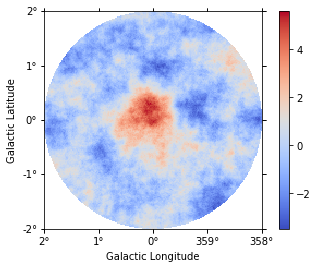

In [16]:
exc0 = est.run(dataset)
exc0.sqrt_ts.plot(add_cbar=True, cmap="coolwarm")

### With the same model

In [17]:
spatial_gauss = GaussianSpatialModel(frame="galactic")

spatial_gauss.lat_0.min = -2
spatial_gauss.lat_0.max = 2

spatial_gauss.lon_0.max = 2
spatial_gauss.lon_0.min = -2

pwl = PowerLawSpectralModel()
pwl.parameters["amplitude"].value = 1e-12
model_gauss = SkyModel(spatial_model=spatial_gauss, spectral_model=pwl, name="gauss")

In [18]:
models = [model_gauss, bkg_model]
dataset.models = models

In [19]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run(datasets=[dataset])

CPU times: user 7.08 s, sys: 36.7 ms, total: 7.11 s
Wall time: 7.02 s


In [20]:
L1 = dataset.stat_sum()
print("Significance of a gauss: ", L0-L1)

Significance of a gauss:  43.95658522413578


In [21]:
dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str16,str8,str9,float64,str14,float64,float64,float64,bool,str1
gauss,spectral,index,2.7058e+00,,3.181e-01,nan,nan,False,
gauss,spectral,amplitude,1.0445e-12,cm-2 s-1 TeV-1,2.385e-13,nan,nan,False,
gauss,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
gauss,spatial,lon_0,1.1182e-01,deg,6.547e-02,-2.000e+00,2.000e+00,False,
gauss,spatial,lat_0,7.4923e-02,deg,7.626e-02,-2.000e+00,2.000e+00,False,
gauss,spatial,sigma,3.0806e-01,deg,4.862e-02,0.000e+00,nan,False,
gauss,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
gauss,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,
dataset-simu-bkg,spectral,norm,9.9206e-01,,2.407e-03,nan,nan,False,


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

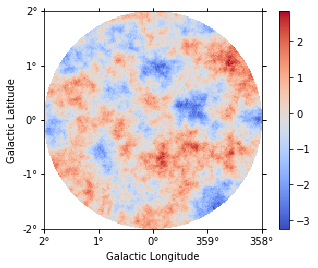

In [22]:
exc1 = est.run(dataset)
exc1.sqrt_ts.plot(add_cbar=True, cmap="coolwarm")

In [23]:
edges = MapAxis.from_energy_bounds(0.5*u.TeV, 10.0*u.TeV, nbin=3, per_decade=True)

In [24]:
fpe = FluxPointsEstimator(energy_edges=edges.edges)

In [25]:
flux_gauss = fpe.run(dataset)

### With a disk

In [26]:
spatial_disk = DiskSpatialModel(frame="galactic")
spatial_disk.parameters["r_0"].value=0.8

spatial_disk.lat_0.min = -2
spatial_disk.lat_0.max = 2

spatial_disk.lon_0.max = 2
spatial_disk.lon_0.min = -2



pwl2 = PowerLawSpectralModel()
pwl2.parameters["amplitude"].value = 1e-12
model_disk = SkyModel(spatial_model=spatial_disk, spectral_model=pwl2,
                      name="disk")

In [27]:
models = [model_disk, bkg_model]
dataset.models = models

In [28]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset])
print(result.success)

W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00157302 is smaller than machine limit 0.0186978 while 0.0002 was requested
True
CPU times: user 11.4 s, sys: 171 ms, total: 11.6 s
Wall time: 11.6 s


In [29]:
L2 = dataset.stat_sum()
print("Significance of a disk: ", L0-L2)

Significance of a disk:  42.9043993508094


In [30]:
dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str16,str8,str10,float64,str14,float64,float64,float64,bool,str1
disk,spectral,index,2.6235e+00,,3.324e-01,nan,nan,False,
disk,spectral,amplitude,1.2428e-12,cm-2 s-1 TeV-1,1.928e-13,nan,nan,False,
disk,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
disk,spatial,lon_0,1.1768e-01,deg,1.565e-02,-2.000e+00,2.000e+00,False,
disk,spatial,lat_0,-1.3878e-01,deg,1.262e-02,-2.000e+00,2.000e+00,False,
disk,spatial,r_0,6.9630e-01,deg,9.723e-03,0.000e+00,nan,False,
disk,spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,
disk,spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,
disk,spatial,edge_width,1.0000e-02,,0.000e+00,0.000e+00,1.000e+00,True,


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

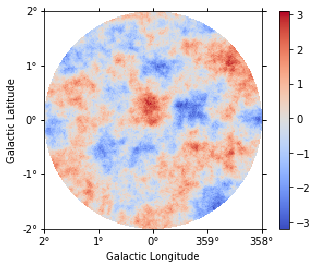

In [31]:
exc2 = est.run(dataset)
exc2.sqrt_ts.plot(add_cbar=True, cmap="coolwarm")

**Conclusion** : Similar spectra inferred from fitting the gauss and the disk

In [32]:
flux_disk = fpe.run(dataset)

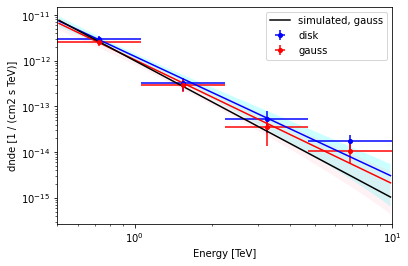

In [33]:
ax = flux_disk.plot(color="blue", label="disk")
pwl2.plot(ax=ax, energy_bounds=[0.5,10]*u.TeV, color="blue")
pwl2.plot_error(ax=ax, energy_bounds=[0.5,10]*u.TeV, facecolor="cyan")

flux_gauss.plot(color="red", label="gauss")
pwl.plot(ax=ax, energy_bounds=[0.5,10]*u.TeV, color="red")
pwl.plot_error(ax=ax, energy_bounds=[0.5,10]*u.TeV, facecolor="pink")

spectral_model.plot(ax=ax, energy_bounds=[0.5,10]*u.TeV, color="black", 
                    label="simulated, gauss")

ax.legend()